# Table of Contents:
1. [Library Imports](#li)
2. [Data Preparation](#dp)
3. [Method Comparison](#mc)
4. [K-Means](#km)
5. [Hierarchical](#h)
6. [DBSCAN](#d)
7. [UMAP](#u)

# 1. Library Imports
<a id='li'></a>

In [1]:
### IMPORTS
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install umap-learn
# !pip install scipy


### LIBRARIES
import pandas as pd
import numpy as np
import umap

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from collections import Counter

from scipy.spatial.distance import cdist

from utils1 import knn_imputer
from utils2 import *

### WARNINGS
import warnings
warnings.filterwarnings('ignore')

### AUTORELOAD
%load_ext autoreload
%autoreload 2

# Set the path to the data files
# path = 'Data/New_Data/project_data_almano_educ_perc.csv'
#path = 'Data/New_Data/project_data_95_educ_perc.csv'
path = 'Data/New_Data/project_data_99_educ_perc.csv'

# 2. Data Preparation
<a id='dp'></a>

#### Import the data

In [2]:
data = pd.read_csv(path)

#### Encode categorical variables

In [3]:
data['relevance_criteria'] = data['relevance_criteria'].replace({'Priority': 2, 'Caution': 1, 'Unknown': 0})
data['gender'] = data['gender'].replace({'female': 0, 'male': 1})
data['education'] = data['education'].replace({'High School': 0, 'Degree': 1, 'BSc Degree': 2, 'MSc Degree': 3})
data.loc[data['returns'] > 0, 'returns'] = 1

#### Define metrics to study

In [10]:
# Metrics to be shown
demographic_metrics_all = ['frequency_items', 'potencial_score', 'longevity_months', 'relevance_criteria', 'recency_in_weeks', 'promotional_percentage', 'returns', 'flaged', 'credit_factor', 'zip_code', 'education', 'gender']
# Metrics considered for clustering
demographic_metrics = ['frequency_items', 'longevity_months', 'relevance_criteria', 'recency_in_weeks', 'promotional_percentage', 'returns', 'flaged']

In [11]:
demographic = data[demographic_metrics_all]
demographic_selection = data[demographic_metrics]

#### Scale the data

In [12]:
# Defining the scalers
standard = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()

In [13]:
# Scaling the data
dem_no_scl = demographic_selection.copy()
dem_st_scl = standard.fit_transform(demographic_selection)
dem_mm_scl = minmax.fit_transform(demographic_selection)
dem_rb_scl = robust.fit_transform(demographic_selection)

In [14]:
# Creating the scaled dataframes
demographic_no_scl = demographic_selection.copy()
demographic_no_scl[demographic_metrics] = dem_no_scl

demographic_st_scl = demographic_selection.copy()
demographic_st_scl[demographic_metrics] = dem_st_scl

demographic_mm_scl = demographic_selection.copy()
demographic_mm_scl[demographic_metrics] = dem_mm_scl

demographic_rb_scl = demographic_selection.copy()
demographic_rb_scl[demographic_metrics] = dem_rb_scl

In [15]:
# Creating equal samples of the differently scaled dataframes
sample_original = demographic.sample(frac=0.2, random_state=1)
sample_no_scl = demographic_no_scl.sample(frac=0.2, random_state=1)
sample_st_scl = demographic_st_scl.sample(frac=0.2, random_state=1)
sample_mm_scl = demographic_mm_scl.sample(frac=0.2, random_state=1)
sample_rb_scl = demographic_rb_scl.sample(frac=0.2, random_state=1)

# Clustering Method Comparison
<a id='mc'></a>

Here different clustering methods performance (based on R^2) will be compared to determine weather if it is even worth it to test all of them. This test will be performed for different types of scaled data.

- [No Scaler](#cmc-no)
- [Standard Scaler](#cmc-st)
- [MinMax Scaler](#cmc-mm)
- [Robust Scaler](#cmc-rb)

First, we will define the base clustering methods to be used in this test. Note that hierarchical clustering will be performed with eucledian distances as this is what is used by k-means, in order to ensure a fair comparison.

In [128]:
kmeans = KMeans(init='k-means++', n_init=10, random_state=1)
hierarchical = AgglomerativeClustering(metric='euclidean')

### No Scale

In [134]:
dem_no_r2_scores = get_r2_df(sample_no_scl, demographic_metrics, kmeans, hierarchical)
dem_no_r2_scores

,kmeans,complete,average,single,ward
2,0.528185,0.500753,0.047871,0.528185,0.528185
3,0.637351,0.588127,0.558928,0.528409,0.622241
4,0.702856,0.604604,0.559652,0.528635,0.693070
5,0.741393,0.616176,0.616420,0.528785,0.727364
6,0.766808,0.639001,0.617078,0.528921,0.746569
7,0.788074,0.685340,0.617149,0.529028,0.765163
8,0.809332,0.701303,0.618338,0.529033,0.783206
9,0.826790,0.702343,0.618388,0.530595,0.800240


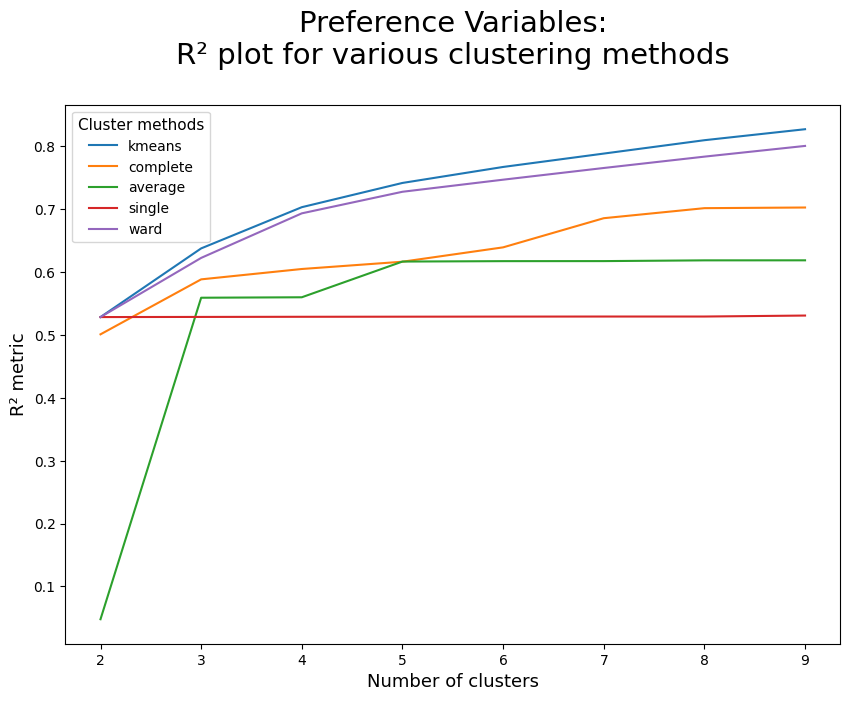

In [135]:
plot_r2_scores(dem_no_r2_scores)

### Standard Scale

In [136]:
dem_st_r2_scores = get_r2_df(sample_st_scl, demographic_metrics, kmeans, hierarchical)
dem_st_r2_scores

,kmeans,complete,average,single,ward
2,0.138208,0.139880,0.139880,0.139880,0.139880
3,0.245348,0.261587,0.261587,0.146147,0.261587
4,0.365834,0.311470,0.267854,0.267854,0.365462
5,0.457971,0.410663,0.268097,0.268110,0.445819
6,0.517687,0.427187,0.289103,0.269541,0.496031
7,0.559282,0.469632,0.392869,0.269630,0.539049
8,0.595630,0.475318,0.393061,0.269740,0.568615
9,0.622036,0.481584,0.393156,0.270381,0.589806


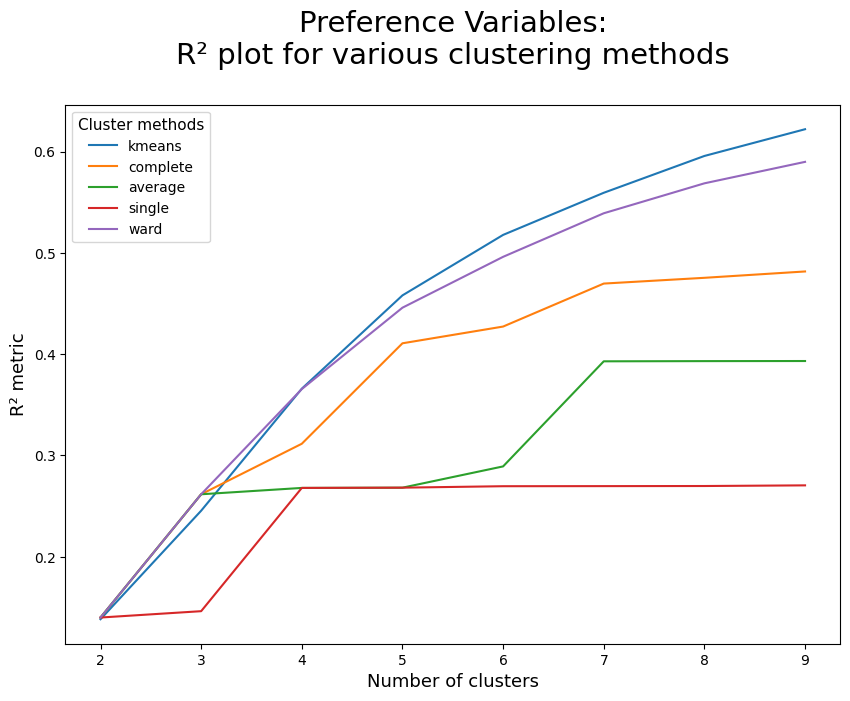

In [137]:
plot_r2_scores(dem_st_r2_scores)

### MinMax Scaler

In [138]:
dem_mm_r2_scores = get_r2_df(sample_mm_scl, demographic_metrics, kmeans, hierarchical)
dem_mm_r2_scores

,kmeans,complete,average,single,ward
2,0.287350,0.040103,0.001261,0.025527,0.243536
3,0.421417,0.182023,0.041371,0.047529,0.386143
4,0.493718,0.262404,0.182748,0.189449,0.478024
5,0.559710,0.278665,0.190174,0.189612,0.532338
6,0.593857,0.286091,0.190362,0.189818,0.566663
7,0.613888,0.535741,0.205436,0.189961,0.600694
8,0.636795,0.537747,0.285833,0.190498,0.622031
9,0.655148,0.540119,0.288204,0.190587,0.637889


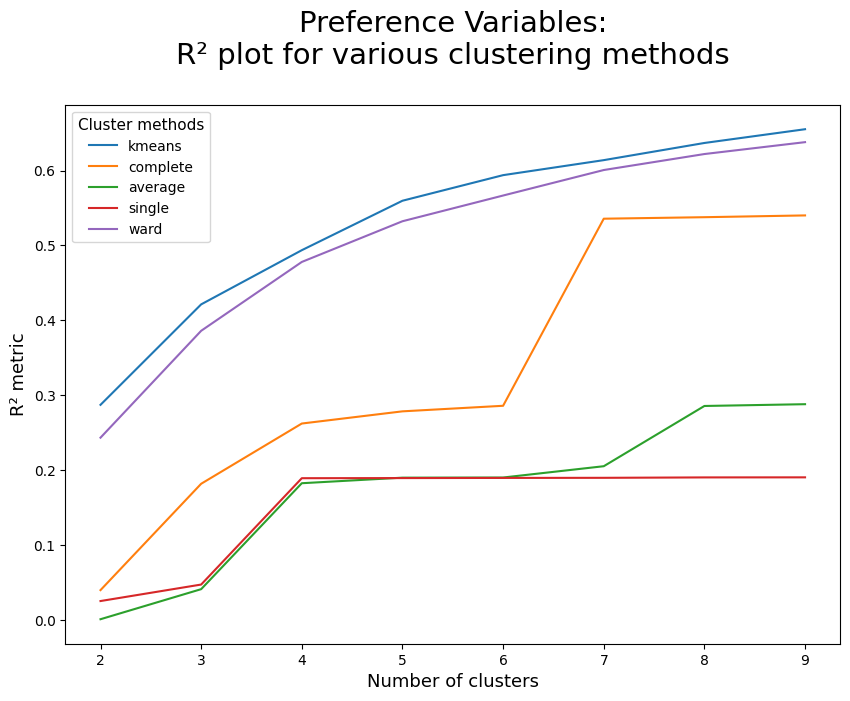

In [139]:
plot_r2_scores(dem_mm_r2_scores)

In [140]:
dem_rb_r2_scores = get_r2_df(sample_rb_scl, demographic_metrics, kmeans, hierarchical)
dem_rb_r2_scores

,kmeans,complete,average,single,ward
2,0.200756,0.043117,0.000359,0.000359,0.184134
3,0.335453,0.144994,0.155846,0.000828,0.311742
4,0.409878,0.262763,0.159680,0.001037,0.370936
5,0.458551,0.325846,0.160187,0.001203,0.412677
6,0.502659,0.326307,0.160363,0.001546,0.447081
7,0.533078,0.353143,0.171422,0.001827,0.474484
8,0.561749,0.357275,0.173287,0.002228,0.496886
9,0.581038,0.370692,0.173785,0.002343,0.517629


### Robust Scaler

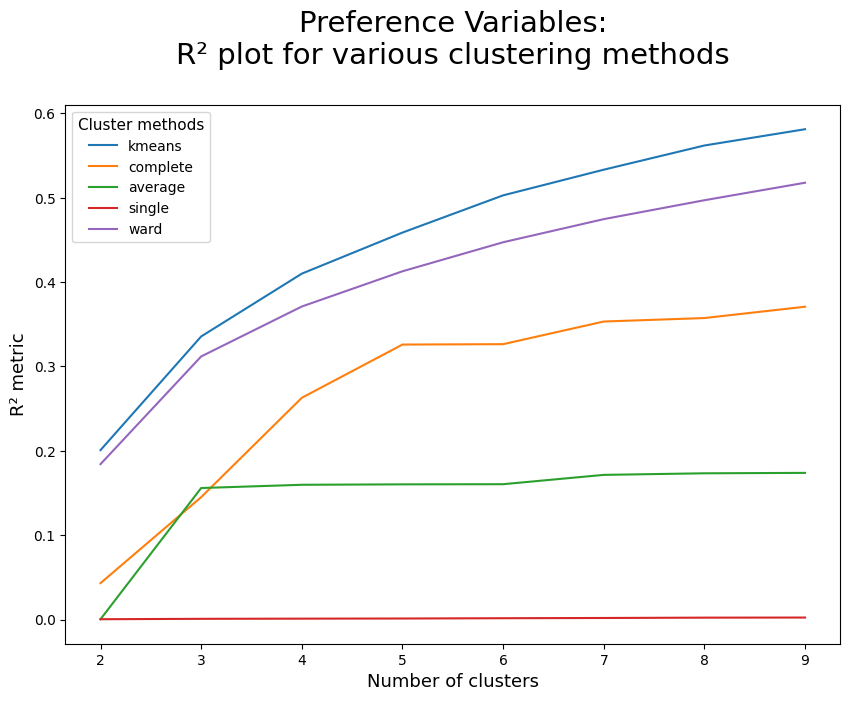

In [141]:
plot_r2_scores(dem_rb_r2_scores)

### Conclusions
<a id='cmc-c'></a>

With this analysis we can confidently focus on using kmeans and hierarchical clustering with ward linkeage to conduct our analysis, as these were shown to  consistently give better results for all types of scaled data.

It is also possible to see that solutions with 3 to 6 clusters will likely yeild the best results, as it is mostly where the graphs present more significant changes in the slope. Additionally, a comparison among scaler results with these preselected clustering techniques was performed.

In [144]:
# Prefix the names of the columns
df_no_prefixed = dem_no_r2_scores.add_prefix("no_")
df_st_prefixed = dem_st_r2_scores.add_prefix("st_")
df_mm_prefixed = dem_mm_r2_scores.add_prefix("mm_")
df_rb_prefixed = dem_rb_r2_scores.add_prefix("rb_")

# Concatenate the dataframes
df_combined = pd.concat([df_no_prefixed, df_st_prefixed, df_mm_prefixed, df_rb_prefixed], axis=1)

# Filter ward and kmeans columns
filtered_columns = [col for col in df_combined.columns if 'ward' in col or 'kmeans' in col]

# Create a new dataframe with only the filtered columns
df_filtered = df_combined[filtered_columns]
df_filtered

,no_kmeans,no_ward,st_kmeans,st_ward,mm_kmeans,mm_ward,rb_kmeans,rb_ward
2,0.528185,0.528185,0.138208,0.139880,0.287350,0.243536,0.200756,0.184134
3,0.637351,0.622241,0.245348,0.261587,0.421417,0.386143,0.335453,0.311742
4,0.702856,0.693070,0.365834,0.365462,0.493718,0.478024,0.409878,0.370936
5,0.741393,0.727364,0.457971,0.445819,0.559710,0.532338,0.458551,0.412677
6,0.766808,0.746569,0.517687,0.496031,0.593857,0.566663,0.502659,0.447081
7,0.788074,0.765163,0.559282,0.539049,0.613888,0.600694,0.533078,0.474484
8,0.809332,0.783206,0.595630,0.568615,0.636795,0.622031,0.561749,0.496886
9,0.826790,0.800240,0.622036,0.589806,0.655148,0.637889,0.581038,0.517629


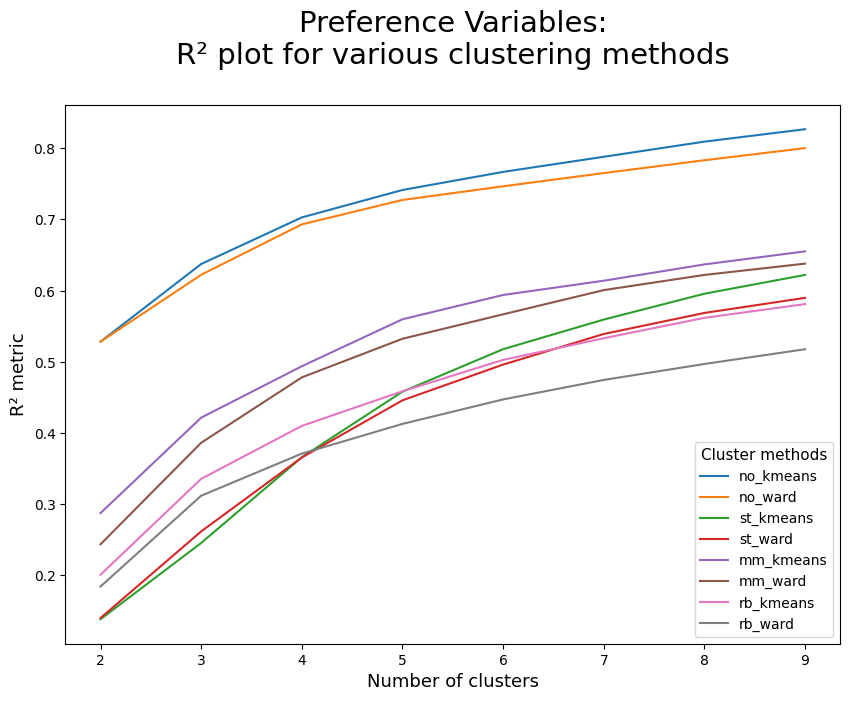

In [145]:
plot_r2_scores(df_filtered)

From the graph it is possible to conclude that **unscaled data** presented the highest performance score, followed by minmax scaler, unscaled data, and standard scaler. The performances for the **standard scaler** and **robust scaler** were the ones that presented worse results, with robust scaler preforming worse for an elevated number of clusters and standard scaler for a lower number of clusters. Nonetheless, similarly to what happened for the preference perspective, all scaling methods were still tested.

---

# 4. Clustering
<a id='cl'></a>

In the notebook, the cluster analysis is grouped by data inputs - no scaling, standard scaler, minmax scaler, robust scaler. In each group, several methods of clustering were used and they are presented in this order:
1. [KMeans](#km)
2. [Ward (Hierarchical)](#wh)
3. [DBScan](#dbs)

In the end, it was possible to identify groups that recurrently appeared in the clustering solutions, and based on this, solutions were chosen to be further studied.

## 4.1. K-means <a id='km'></a>

In this section, the k-means algorithm was tested with the data inputs previously mentioned. For each of the data inputs inertia and silhuette plots were done in order to decide which number of cluester were going to be considered for testing. Then, the clusters formed were analysed and clustering solutions compared. The tests for each data input were presented in the following order:
1. [No Scaler](#km-no)
2. [Standard Scaler](#km-st)
3. [MinMax Scaler](#km-mm)
4. [Robust Scaler](#km-rb)

### No Scaler <a id='km-no'></a>

#### Plot

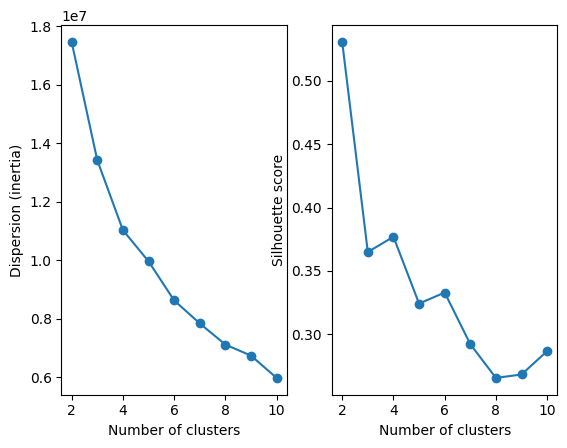

In [22]:
plot_inertia_and_silhouette(sample_no_scl, 2, 10)

#### Models

##### 3 clusters

In [16]:
kmeans = KMeans(n_clusters = 3, init='k-means++', n_init=20,  random_state = 1).fit(sample_no_scl)
sample_original['no_kmeans3'] = kmeans.predict(sample_no_scl)

In [17]:
groupby_mean(sample_original, 'no_kmeans3', True)

# observations per cluster: [8594, 3422, 12410]


no_kmeans3,0,1,2
frequency_items,51.420000,38.000000,29.050000
potencial_score,30.270000,27.840000,28.980000
longevity_months,15.950000,13.780000,14.670000
relevance_criteria,1.900000,2.000000,1.910000
recency_in_weeks,15.260000,15.370000,15.250000
promotional_percentage,5.820000,44.120000,6.430000
returns,0.040000,0.110000,0.020000
flaged,0.010000,0.000000,0.010000
credit_factor,0.820000,1.410000,0.820000
zip_code,4.510000,4.070000,4.910000


lowscore | score | general

##### 4 clusters

In [18]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init=20,  random_state = 1).fit(sample_no_scl)
sample_original['no_kmeans4'] = kmeans.predict(sample_no_scl)

In [19]:
groupby_mean(sample_original, 'no_kmeans4', True)

# observations per cluster: [11683, 8088, 746, 3909]


no_kmeans4,0,1,2,3
frequency_items,29.050000,51.780000,38.970000,37.130000
potencial_score,29.030000,30.410000,36.890000,26.220000
longevity_months,14.690000,16.080000,15.290000,13.600000
relevance_criteria,1.910000,1.900000,2.000000,2.000000
recency_in_weeks,15.250000,15.230000,14.820000,15.500000
promotional_percentage,5.190000,5.100000,75.170000,31.430000
returns,0.030000,0.040000,0.370000,0.030000
flaged,0.010000,0.010000,0.000000,0.000000
credit_factor,0.790000,0.800000,0.980000,1.460000
zip_code,4.920000,4.530000,5.030000,4.030000


general | score | lowscore | promo

##### 5 clusters

In [20]:
kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=20,  random_state = 1).fit(sample_no_scl)
sample_original['no_kmeans5'] = kmeans.predict(sample_no_scl)

In [21]:
groupby_mean(sample_original, 'no_kmeans5', True)

# observations per cluster: [7573, 745, 7385, 3758, 4965]


no_kmeans5,0,1,2,3,4
frequency_items,39.300000,38.990000,25.270000,37.160000,56.300000
potencial_score,24.250000,36.890000,31.760000,26.270000,34.390000
longevity_months,10.220000,15.300000,17.860000,13.530000,19.090000
relevance_criteria,1.900000,2.000000,1.910000,2.000000,1.900000
recency_in_weeks,15.330000,14.820000,15.190000,15.540000,15.160000
promotional_percentage,4.700000,75.200000,5.650000,31.800000,5.620000
returns,0.030000,0.370000,0.030000,0.040000,0.040000
flaged,0.010000,0.000000,0.010000,0.000000,0.020000
credit_factor,0.750000,0.980000,0.820000,1.480000,0.820000
zip_code,3.890000,5.020000,5.480000,4.030000,5.010000


promo | score | lowscore | general | promo+returns+score

#### Comparison

In [22]:
clusters_comparison(sample_original, 'no_kmeans4', 'no_kmeans3')

,no_kmeans3 0 Cluster,no_kmeans3 1 Cluster,no_kmeans3 2 Cluster
no_kmeans4 0 Cluster,137,0,11546
no_kmeans4 1 Cluster,8085,1,2
no_kmeans4 2 Cluster,0,746,0
no_kmeans4 3 Cluster,372,2675,862


In [23]:
clusters_comparison(sample_original, 'no_kmeans5', 'no_kmeans4')

,no_kmeans4 0 Cluster,no_kmeans4 1 Cluster,no_kmeans4 2 Cluster,no_kmeans4 3 Cluster
no_kmeans5 0 Cluster,4379,3097,0,97
no_kmeans5 1 Cluster,0,0,745,0
no_kmeans5 2 Cluster,7287,34,0,64
no_kmeans5 3 Cluster,17,18,1,3722
no_kmeans5 4 Cluster,0,4939,0,26


### Standard Scaler <a id='km-st'></a>

#### Plot

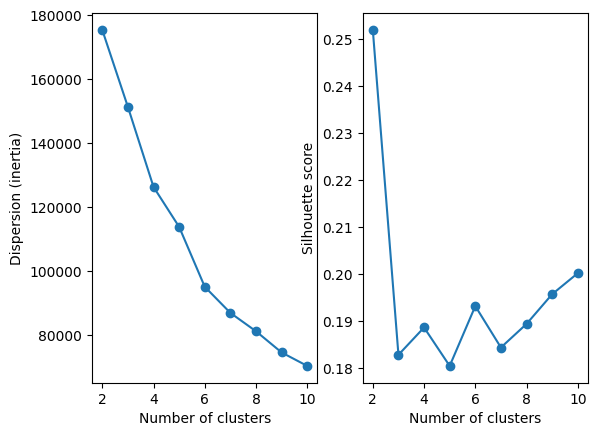

In [23]:
plot_inertia_and_silhouette(sample_st_scl, 2, 10)

#### Models

##### 3 clusters

In [24]:
kmeans = KMeans(n_clusters = 3, init='k-means++', n_init=20,  random_state = 1).fit(sample_st_scl)
sample_original['st_kmeans3'] = kmeans.predict(sample_st_scl)

In [25]:
groupby_mean(sample_original, 'st_kmeans3', True)

# observations per cluster: [1319, 22898, 209]


st_kmeans3,0,1,2
frequency_items,38.760000,38.110000,41.760000
potencial_score,29.900000,29.070000,47.880000
longevity_months,15.020000,14.970000,17.630000
relevance_criteria,0.680000,2.000000,1.230000
recency_in_weeks,15.710000,15.260000,13.570000
promotional_percentage,0.280000,12.250000,0.000000
returns,0.040000,0.040000,0.390000
flaged,0.000000,0.000000,1.000000
credit_factor,0.640000,0.920000,0.780000
zip_code,4.490000,4.650000,6.540000


lowscore | score | nopromo+returns

##### 4 clusters

In [26]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init=20,  random_state = 1).fit(sample_st_scl)
sample_original['st_kmeans4'] = kmeans.predict(sample_st_scl)

In [27]:
groupby_mean(sample_original, 'st_kmeans4', True)

# observations per cluster: [944, 9869, 209, 13404]


st_kmeans4,0,1,2,3
frequency_items,39.460000,42.640000,41.760000,34.750000
potencial_score,38.310000,33.780000,47.880000,25.040000
longevity_months,16.160000,22.600000,17.630000,9.270000
relevance_criteria,1.940000,1.860000,1.230000,1.980000
recency_in_weeks,14.700000,15.320000,13.570000,15.300000
promotional_percentage,31.210000,7.990000,0.000000,12.860000
returns,1.000000,0.000000,0.390000,0.000000
flaged,0.000000,0.000000,1.000000,0.000000
credit_factor,0.980000,0.860000,0.780000,0.930000
zip_code,5.150000,5.310000,6.540000,4.110000


promo+returns | general | nopromo | nopromo+score+returns

##### 6 clusters

In [28]:
kmeans = KMeans(n_clusters = 6, init='k-means++', n_init=20,  random_state = 1).fit(sample_st_scl)
sample_original['st_kmeans6'] = kmeans.predict(sample_st_scl)

In [29]:
groupby_mean(sample_original, 'st_kmeans6', True)

# observations per cluster: [7553, 6589, 209, 937, 1272, 7866]


st_kmeans6,0,1,2,3,4,5
frequency_items,35.110000,43.680000,41.760000,39.440000,38.780000,36.170000
potencial_score,28.960000,34.570000,47.880000,38.250000,29.050000,23.620000
longevity_months,11.810000,24.730000,17.630000,16.180000,15.020000,9.680000
relevance_criteria,2.000000,2.000000,1.230000,1.950000,0.670000,2.000000
recency_in_weeks,11.660000,15.770000,13.570000,14.720000,15.760000,18.350000
promotional_percentage,12.030000,9.230000,0.000000,31.440000,0.150000,12.650000
returns,0.000000,0.000000,0.390000,1.000000,0.010000,0.000000
flaged,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
credit_factor,0.850000,0.920000,0.780000,0.990000,0.630000,0.980000
zip_code,4.780000,5.420000,6.540000,5.160000,4.430000,3.810000


score | lowscore | nopromo1 | promo+returns | antiques | nopromo2

#### Comparison

In [30]:
clusters_comparison(sample_original, 'st_kmeans4', 'st_kmeans3')

,st_kmeans3 0 Cluster,st_kmeans3 1 Cluster,st_kmeans3 2 Cluster
st_kmeans4 0 Cluster,54,890,0
st_kmeans4 1 Cluster,997,8872,0
st_kmeans4 2 Cluster,0,0,209
st_kmeans4 3 Cluster,268,13136,0


In [31]:
clusters_comparison(sample_original, 'st_kmeans6', 'st_kmeans4')

,st_kmeans4 0 Cluster,st_kmeans4 1 Cluster,st_kmeans4 2 Cluster,st_kmeans4 3 Cluster
st_kmeans6 0 Cluster,0,1497,0,6056
st_kmeans6 1 Cluster,0,6551,0,38
st_kmeans6 2 Cluster,0,0,209,0
st_kmeans6 3 Cluster,937,0,0,0
st_kmeans6 4 Cluster,7,997,0,268
st_kmeans6 5 Cluster,0,824,0,7042


### MinMax Scaler <a id='km-mm'></a>

#### Plot

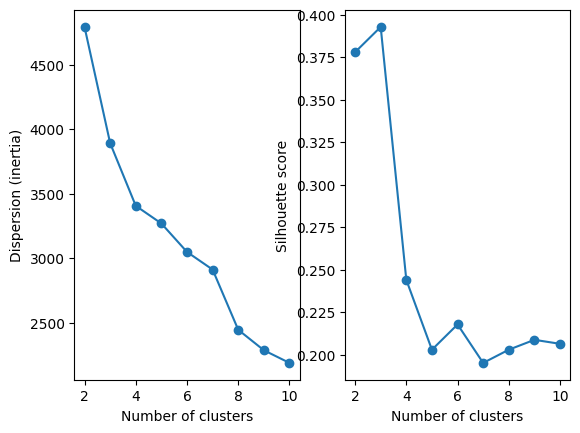

In [24]:
plot_inertia_and_silhouette(sample_mm_scl, 2, 10)

#### Models

##### 3 clusters

In [32]:
kmeans = KMeans(n_clusters = 3, init='k-means++', n_init=20,  random_state = 1).fit(sample_mm_scl)
sample_original['mm_kmeans3'] = kmeans.predict(sample_mm_scl)

In [34]:
groupby_mean(sample_original, 'mm_kmeans3', True)

# observations per cluster: [10020, 13381, 1025]


mm_kmeans3,0,1,2
frequency_items,39.160000,37.320000,39.690000
potencial_score,34.010000,24.970000,39.260000
longevity_months,23.220000,8.730000,16.380000
relevance_criteria,1.900000,1.950000,1.880000
recency_in_weeks,15.150000,15.410000,14.570000
promotional_percentage,9.220000,11.870000,28.740000
returns,0.000000,0.000000,1.000000
flaged,0.010000,0.000000,0.080000
credit_factor,0.880000,0.920000,0.970000
zip_code,5.430000,4.020000,5.300000


general | score | promo+returns

##### 4 clusters

In [37]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init=20,  random_state = 1).fit(sample_mm_scl)
sample_original['mm_kmeans4'] = kmeans.predict(sample_mm_scl)

In [38]:
groupby_mean(sample_original, 'mm_kmeans4', True)

# observations per cluster: [9315, 12727, 1025, 1359]


mm_kmeans4,0,1,2,3
frequency_items,39.110000,37.260000,39.690000,39.160000
potencial_score,34.040000,24.900000,39.260000,30.090000
longevity_months,23.360000,8.740000,16.380000,15.190000
relevance_criteria,2.000000,2.000000,1.880000,0.700000
recency_in_weeks,15.120000,15.400000,14.570000,15.670000
promotional_percentage,10.070000,12.360000,28.740000,0.140000
returns,0.000000,0.000000,1.000000,0.000000
flaged,0.000000,0.000000,0.080000,0.070000
credit_factor,0.900000,0.930000,0.970000,0.640000
zip_code,5.470000,4.010000,5.300000,4.550000


lowscore | score | antiques+lowpromo | promo+returns

##### 5 clusters

In [39]:
kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=20,  random_state = 1).fit(sample_mm_scl)
sample_original['mm_kmeans5'] = kmeans.predict(sample_mm_scl)

In [41]:
groupby_mean(sample_original, 'mm_kmeans5', True)

# observations per cluster: [7635, 7359, 1025, 1359, 7048]


mm_kmeans5,0,1,2,3,4
frequency_items,37.520000,37.430000,39.690000,39.160000,39.250000
potencial_score,23.620000,28.640000,39.260000,30.090000,34.470000
longevity_months,9.300000,11.050000,16.380000,15.190000,25.050000
relevance_criteria,2.000000,2.000000,1.880000,0.700000,2.000000
recency_in_weeks,18.370000,11.740000,14.570000,15.670000,15.620000
promotional_percentage,12.450000,11.730000,28.740000,0.140000,9.900000
returns,0.000000,0.000000,1.000000,0.000000,0.000000
flaged,0.000000,0.000000,0.080000,0.070000,0.000000
credit_factor,0.980000,0.850000,0.970000,0.640000,0.920000
zip_code,3.760000,4.660000,5.300000,4.550000,5.550000


antiques | promo+returns | score | nopromo | lowscore+new

##### 6 clusters

In [42]:
kmeans = KMeans(n_clusters = 6, init='k-means++', n_init=20,  random_state = 1).fit(sample_mm_scl)
sample_original['mm_kmeans6'] = kmeans.predict(sample_mm_scl)

In [43]:
groupby_mean(sample_original, 'mm_kmeans6', True)

# observations per cluster: [6550, 2358, 6775, 1358, 1025, 6360]


mm_kmeans6,0,1,2,3,4,5
frequency_items,37.580000,38.710000,37.410000,39.160000,39.690000,38.950000
potencial_score,23.920000,28.280000,28.340000,30.050000,39.260000,34.390000
longevity_months,9.960000,13.540000,10.340000,15.200000,16.380000,25.420000
relevance_criteria,2.000000,2.000000,2.000000,0.700000,1.880000,2.000000
recency_in_weeks,18.770000,14.930000,11.910000,15.670000,14.570000,15.400000
promotional_percentage,8.290000,43.070000,7.170000,0.090000,28.740000,7.350000
returns,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
flaged,0.000000,0.000000,0.000000,0.070000,0.080000,0.000000
credit_factor,0.910000,1.400000,0.770000,0.640000,0.970000,0.910000
zip_code,3.840000,4.210000,4.640000,4.550000,5.300000,5.580000


nopromo | antiques | score | lowscore | lowscore+new | promo+returns

#### Comparison

In [44]:
clusters_comparison(sample_original, 'mm_kmeans4', 'mm_kmeans3')

,mm_kmeans3 0 Cluster,mm_kmeans3 1 Cluster,mm_kmeans3 2 Cluster
mm_kmeans4 0 Cluster,9247,68,0
mm_kmeans4 1 Cluster,2,12725,0
mm_kmeans4 2 Cluster,0,0,1025
mm_kmeans4 3 Cluster,771,588,0


In [45]:
clusters_comparison(sample_original, 'mm_kmeans5', 'mm_kmeans4')

,mm_kmeans4 0 Cluster,mm_kmeans4 1 Cluster,mm_kmeans4 2 Cluster,mm_kmeans4 3 Cluster
mm_kmeans5 0 Cluster,710,6925,0,0
mm_kmeans5 1 Cluster,1557,5802,0,0
mm_kmeans5 2 Cluster,0,0,1025,0
mm_kmeans5 3 Cluster,0,0,0,1359
mm_kmeans5 4 Cluster,7048,0,0,0


In [46]:
clusters_comparison(sample_original, 'mm_kmeans6', 'mm_kmeans5')

,mm_kmeans5 0 Cluster,mm_kmeans5 1 Cluster,mm_kmeans5 2 Cluster,mm_kmeans5 3 Cluster,mm_kmeans5 4 Cluster
mm_kmeans6 0 Cluster,6256,0,0,0,294
mm_kmeans6 1 Cluster,903,971,0,1,483
mm_kmeans6 2 Cluster,476,6291,0,0,8
mm_kmeans6 3 Cluster,0,0,0,1358,0
mm_kmeans6 4 Cluster,0,0,1025,0,0
mm_kmeans6 5 Cluster,0,97,0,0,6263


### Robust Scaler <a id='km-rb'></a>

#### Plot

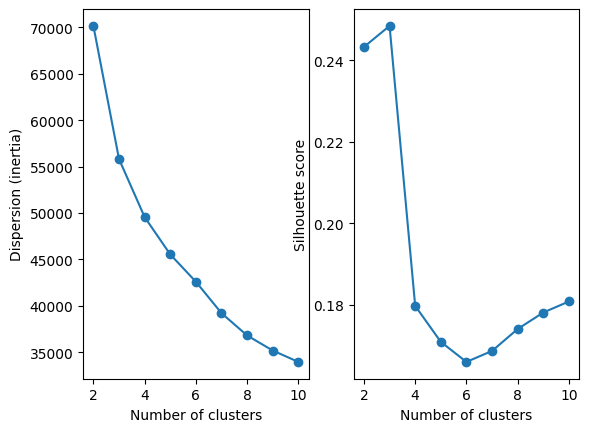

In [25]:
plot_inertia_and_silhouette(sample_rb_scl, 2, 10)

#### Models

##### 3 clusters

In [47]:
kmeans = KMeans(n_clusters = 3, init='k-means++', n_init=20,  random_state = 1).fit(sample_rb_scl)
sample_original['rb_kmeans3'] = kmeans.predict(sample_rb_scl)

In [48]:
groupby_mean(sample_original, 'rb_kmeans3', True)

# observations per cluster: [3433, 10104, 10889]


rb_kmeans3,0,1,2
frequency_items,38.460000,38.210000,38.060000
potencial_score,28.060000,27.750000,31.080000
longevity_months,13.790000,15.100000,15.270000
relevance_criteria,2.000000,1.910000,1.910000
recency_in_weeks,15.400000,18.510000,12.220000
promotional_percentage,44.170000,6.110000,6.190000
returns,0.110000,0.030000,0.030000
flaged,0.000000,0.010000,0.010000
credit_factor,1.400000,0.860000,0.780000
zip_code,4.090000,4.460000,5.010000


score | promo+(returns) | lowscore?

##### 4 clusters

In [49]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init=20,  random_state = 1).fit(sample_rb_scl)
sample_original['rb_kmeans4'] = kmeans.predict(sample_rb_scl)

In [50]:
groupby_mean(sample_original, 'rb_kmeans4', True)

# observations per cluster: [7557, 5672, 7968, 3229]


rb_kmeans4,0,1,2,3
frequency_items,32.330000,54.830000,31.800000,38.330000
potencial_score,26.600000,32.940000,29.710000,28.030000
longevity_months,13.960000,17.990000,14.290000,13.910000
relevance_criteria,1.910000,1.890000,1.920000,2.000000
recency_in_weeks,18.730000,15.280000,11.960000,15.320000
promotional_percentage,6.610000,5.780000,6.560000,45.160000
returns,0.020000,0.040000,0.030000,0.120000
flaged,0.000000,0.010000,0.010000,0.000000
credit_factor,0.870000,0.830000,0.790000,1.390000
zip_code,4.420000,4.800000,5.010000,4.080000


recent+lowscore | general | promo+(returns) | score

##### 5 clusters

In [51]:
kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=20,  random_state = 1).fit(sample_rb_scl)
sample_original['rb_kmeans5'] = kmeans.predict(sample_rb_scl)

In [52]:
groupby_mean(sample_original, 'rb_kmeans5', True)

# observations per cluster: [7523, 747, 3719, 7100, 5337]


rb_kmeans5,0,1,2,3,4
frequency_items,31.720000,38.990000,37.480000,32.450000,55.260000
potencial_score,29.710000,36.830000,26.280000,26.750000,33.070000
longevity_months,14.390000,15.270000,13.480000,14.200000,17.920000
relevance_criteria,1.920000,2.000000,2.000000,1.900000,1.890000
recency_in_weeks,11.900000,14.810000,15.670000,18.740000,15.200000
promotional_percentage,5.550000,75.140000,31.960000,5.130000,5.170000
returns,0.030000,0.370000,0.030000,0.020000,0.040000
flaged,0.010000,0.000000,0.000000,0.010000,0.020000
credit_factor,0.760000,0.980000,1.500000,0.810000,0.810000
zip_code,5.020000,5.030000,4.000000,4.450000,4.820000


### Comparison

In [166]:
clusters_comparison(sample_original, 'rb_kmeans4', 'rb_kmeans3')

,rb_kmeans3 0 Cluster,rb_kmeans3 1 Cluster,rb_kmeans3 2 Cluster
rb_kmeans4 0 Cluster,1,215,7926
rb_kmeans4 1 Cluster,20,32,8154
rb_kmeans4 2 Cluster,5,2987,0
rb_kmeans4 3 Cluster,5072,2,12


## 4.2. Hierarchical (Ward) <a id='wh'></a>

In this section, the hierarchical algorithm with a ward linkeage method was tested with the data inputs previously mentioned. For each of the data inputs dendrograms were plotted in order to decide which number of cluester were going to be considered for testing. Then, the clusters formed were analysed and clustering solutions compared. The tests for each data input were presented in the following order:
1. [No Scaler](#h-no)
2. [Standard Scaler](#h-st)
3. [MinMax Scaler](#h-mm)
4. [Robust Scaler](#h-rb)

In the end of this section there is also a result comparison between clustering techniques as well as scaling options.

5. [Inter Clustering Comparison](#icc)

### No Scaler <a id='h-no'></a>

#### Plot

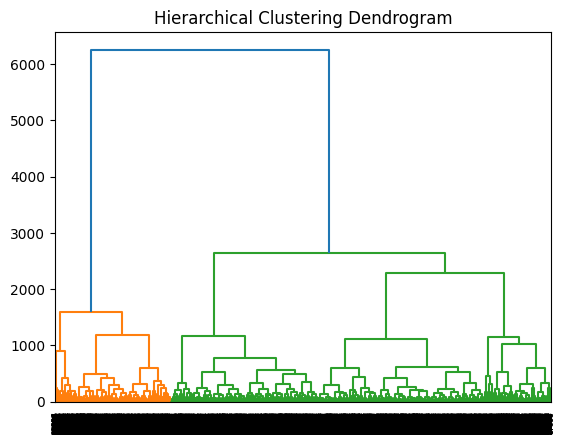

In [62]:
plot_dendrogram(sample_no_scl, 'ward')

#### Models

##### 2 clusters

In [66]:
sample_original['no_ward2'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 2
    ).fit_predict(sample_no_scl)

In [98]:
groupby_mean(sample_original, 'no_ward2', True, 12, 1)

# observations per cluster: [18682, 5744]


no_ward2,0,1
frequency_items,37.460000,40.520000
potencial_score,13.620000,80.200000
longevity_months,14.520000,16.530000
relevance_criteria,1.930000,1.910000
recency_in_weeks,15.420000,14.780000
promotional_percentage,11.100000,12.800000
returns,0.030000,0.070000
flaged,0.010000,0.020000
credit_factor,0.940000,0.800000
zip_code,3.720000,7.680000


general | score

##### 3 clusters

In [68]:
sample_original['no_ward3'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 3
    ).fit_predict(sample_no_scl)

In [101]:
groupby_mean(sample_original, 'no_ward3', False, 12, 0)

no_ward3,0,1,2,data
frequency_items,39.23,40.52,34.64,38.18
potencial_score,3.53,80.20,29.64,29.28
longevity_months,13.35,16.53,16.39,14.99
relevance_criteria,1.93,1.91,1.92,1.92
recency_in_weeks,15.58,14.78,15.17,15.27
promotional_percentage,14.41,12.80,5.83,11.49
returns,0.04,0.07,0.02,0.04
flaged,0.00,0.02,0.01,0.01
credit_factor,1.02,0.80,0.80,0.90
zip_code,1.23,7.68,7.68,4.65


lowscore+(new) | score | lowpromo

##### 4 clusters

In [70]:
sample_original['no_ward4'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 4
    ).fit_predict(sample_no_scl)

In [71]:
groupby_mean(sample_original, 'no_ward4', True, 12)

# observations per cluster: [5744, 3264, 7221, 8197]


no_ward4,0,1,2,3
frequency_items,40.520000,38.700000,34.640000,39.440000
potencial_score,80.200000,11.130000,29.640000,0.510000
longevity_months,16.530000,13.850000,16.390000,13.150000
relevance_criteria,1.910000,2.000000,1.920000,1.900000
recency_in_weeks,14.780000,15.620000,15.170000,15.560000
promotional_percentage,12.800000,37.130000,5.830000,5.370000
returns,0.070000,0.070000,0.020000,0.030000
flaged,0.020000,0.000000,0.010000,0.010000
credit_factor,0.800000,1.460000,0.800000,0.840000
zip_code,7.680000,3.060000,7.680000,0.500000


score | promo | general | lowscore

##### 5 clusters

In [72]:
sample_original['no_ward5'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 5
    ).fit_predict(sample_no_scl)

In [73]:
groupby_mean(sample_original, 'no_ward5', True, 12)

# observations per cluster: [4679, 3264, 7221, 8197, 1065]


no_ward5,0,1,2,3,4
frequency_items,41.260000,38.700000,34.640000,39.440000,37.260000
potencial_score,80.140000,11.130000,29.640000,0.510000,80.450000
longevity_months,16.430000,13.850000,16.390000,13.150000,16.950000
relevance_criteria,1.890000,2.000000,1.920000,1.900000,2.000000
recency_in_weeks,14.790000,15.620000,15.170000,15.560000,14.740000
promotional_percentage,5.740000,37.130000,5.830000,5.370000,43.780000
returns,0.050000,0.070000,0.020000,0.030000,0.160000
flaged,0.020000,0.000000,0.010000,0.010000,0.000000
credit_factor,0.780000,1.460000,0.800000,0.840000,0.930000
zip_code,7.690000,3.060000,7.680000,0.500000,7.630000


score | promo+(lowscore) | general | lowscore | score+promo

#### Comparison

In [167]:
clusters_comparison(sample_original, 'no_ward3', 'no_ward2')

,no_ward2 0 Cluster,no_ward2 1 Cluster
no_ward3 0 Cluster,11461,0
no_ward3 1 Cluster,0,5744
no_ward3 2 Cluster,7221,0


In [168]:
clusters_comparison(sample_original, 'no_ward4', 'no_ward3')

,no_ward3 0 Cluster,no_ward3 1 Cluster,no_ward3 2 Cluster
no_ward4 0 Cluster,0,5744,0
no_ward4 1 Cluster,3264,0,0
no_ward4 2 Cluster,0,0,7221
no_ward4 3 Cluster,8197,0,0


In [169]:
clusters_comparison(sample_original, 'no_ward5', 'no_ward4')

,no_ward4 0 Cluster,no_ward4 1 Cluster,no_ward4 2 Cluster,no_ward4 3 Cluster
no_ward5 0 Cluster,4679,0,0,0
no_ward5 1 Cluster,0,3264,0,0
no_ward5 2 Cluster,0,0,7221,0
no_ward5 3 Cluster,0,0,0,8197
no_ward5 4 Cluster,1065,0,0,0


### Standard Scaler <a id='h-st'></a>

#### Plot

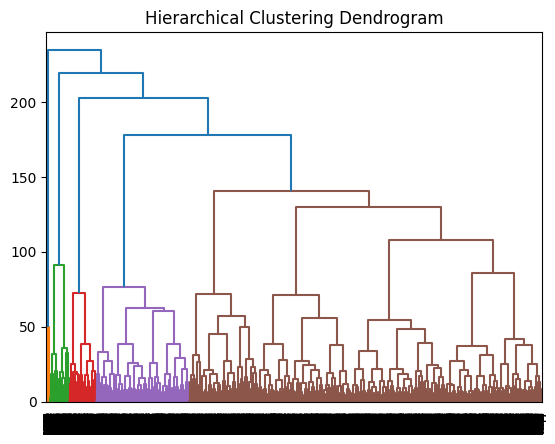

In [63]:
plot_dendrogram(sample_st_scl, 'ward')

#### Models

##### 5 clusters

In [74]:
sample_original['st_ward5'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 5
    ).fit_predict(sample_st_scl)

In [75]:
groupby_mean(sample_original, 'st_ward5', True)

# observations per cluster: [17573, 4436, 944, 209, 1264]


st_ward5,0,1,2,3,4
frequency_items,37.420000,40.540000,39.460000,41.760000,38.760000
potencial_score,15.760000,80.150000,38.310000,47.880000,28.910000
longevity_months,14.480000,16.630000,16.160000,17.630000,15.030000
relevance_criteria,2.000000,2.000000,1.940000,1.230000,0.670000
recency_in_weeks,15.390000,14.840000,14.700000,13.570000,15.770000
promotional_percentage,12.270000,8.020000,31.210000,0.000000,0.100000
returns,0.000000,0.000000,1.000000,0.390000,0.000000
flaged,0.000000,0.000000,0.000000,1.000000,0.000000
credit_factor,0.950000,0.800000,0.980000,0.780000,0.630000
zip_code,3.860000,7.660000,5.150000,6.540000,4.430000


general | score | promo+return | flag+nopromo | flag+nopromo

##### 8 clusters

In [76]:
sample_original['st_ward8'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 8
    ).fit_predict(sample_st_scl)

In [77]:
groupby_mean(sample_original, 'st_ward8', True, 12)

# observations per cluster: [944, 4436, 4888, 4898, 1264, 3318, 4469, 209]


st_ward8,0,1,2,3,4,5,6,7
frequency_items,39.460000,40.540000,43.010000,32.660000,38.760000,37.590000,36.420000,41.760000
potencial_score,38.310000,80.150000,10.740000,12.070000,28.910000,22.340000,20.400000,47.880000
longevity_months,16.160000,16.630000,9.390000,11.450000,15.030000,12.970000,24.510000,17.630000
relevance_criteria,1.940000,2.000000,2.000000,2.000000,0.670000,2.000000,2.000000,1.230000
recency_in_weeks,14.700000,14.840000,17.580000,12.610000,15.770000,15.480000,15.990000,13.570000
promotional_percentage,31.210000,8.020000,6.350000,6.840000,0.100000,37.100000,6.260000,0.000000
returns,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.390000
flaged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
credit_factor,0.980000,0.800000,0.840000,0.770000,0.630000,1.420000,0.910000,0.780000
zip_code,5.150000,7.660000,2.900000,3.390000,4.430000,3.780000,5.490000,6.540000


promo+returns | score | lowscore | ? | nopromo | promo | antiques | nopromo+flag

### MinMax Scaler <a id='h-mm'></a>

#### Plot

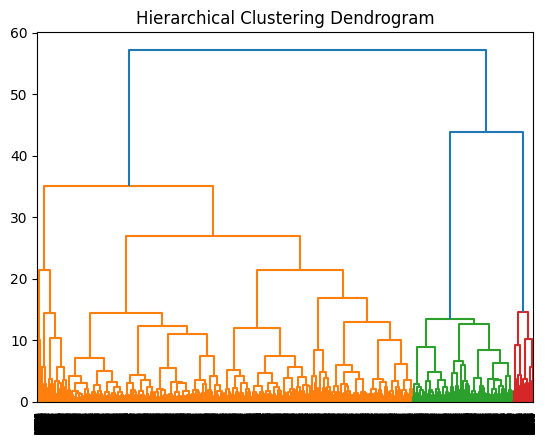

In [64]:
plot_dendrogram(sample_mm_scl, 'ward')

#### Models

##### 2 clusters

In [78]:
sample_original['mm_ward2'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 2
    ).fit_predict(sample_mm_scl)

In [79]:
groupby_mean(sample_original, 'mm_ward2', True, 12)

# observations per cluster: [5917, 18509]


mm_ward2,0,1
frequency_items,40.330000,37.490000
potencial_score,73.480000,15.150000
longevity_months,16.450000,14.530000
relevance_criteria,1.990000,1.900000
recency_in_weeks,14.780000,15.430000
promotional_percentage,15.230000,10.300000
returns,0.160000,0.000000
flaged,0.000000,0.010000
credit_factor,0.840000,0.920000
zip_code,7.260000,3.820000


score | general

##### 3 clusters

In [80]:
sample_original['mm_ward3'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 3
    ).fit_predict(sample_mm_scl)

In [81]:
groupby_mean(sample_original, 'mm_ward3', True, 12)

# observations per cluster: [18509, 944, 4973]


mm_ward3,0,1,2
frequency_items,37.490000,39.460000,40.490000
potencial_score,15.150000,38.310000,80.160000
longevity_months,14.530000,16.160000,16.510000
relevance_criteria,1.900000,1.940000,2.000000
recency_in_weeks,15.430000,14.700000,14.800000
promotional_percentage,10.300000,31.210000,12.200000
returns,0.000000,1.000000,0.000000
flaged,0.010000,0.000000,0.000000
credit_factor,0.920000,0.980000,0.810000
zip_code,3.820000,5.150000,7.660000


general | promo+returns | score

##### 4 clusters

In [82]:
sample_original['mm_ward4'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 4
    ).fit_predict(sample_mm_scl)

In [83]:
groupby_mean(sample_original, 'mm_ward4', True, 12)

# observations per cluster: [17036, 1473, 4973, 944]


mm_ward4,0,1,2,3
frequency_items,37.340000,39.180000,40.490000,39.460000
potencial_score,13.720000,31.600000,80.160000,38.310000
longevity_months,14.450000,15.400000,16.510000,16.160000
relevance_criteria,2.000000,0.750000,2.000000,1.940000
recency_in_weeks,15.420000,15.460000,14.800000,14.700000
promotional_percentage,11.180000,0.090000,12.200000,31.210000
returns,0.000000,0.050000,0.000000,1.000000
flaged,0.000000,0.140000,0.000000,0.000000
credit_factor,0.950000,0.650000,0.810000,0.980000
zip_code,3.740000,4.730000,7.660000,5.150000


lowscore | nopromo | score | promo+returns

##### 5 clusters

In [84]:
sample_original['mm_ward5'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 5
    ).fit_predict(sample_mm_scl)

In [159]:
groupby_mean(sample_original, 'mm_ward5', True, 12)

# observations per cluster: [9301, 1473, 4973, 944, 7735]


mm_ward5,0,1,2,3,4
frequency_items,35.920000,39.180000,40.490000,39.460000,39.050000
potencial_score,24.720000,31.600000,80.160000,38.310000,0.500000
longevity_months,17.810000,15.400000,16.510000,16.160000,10.420000
relevance_criteria,2.000000,0.750000,2.000000,1.940000,2.000000
recency_in_weeks,15.050000,15.460000,14.800000,14.700000,15.870000
promotional_percentage,11.490000,0.090000,12.200000,31.210000,10.810000
returns,0.000000,0.050000,0.000000,1.000000,0.000000
flaged,0.000000,0.140000,0.000000,0.000000,0.000000
credit_factor,0.850000,0.650000,0.810000,0.980000,1.070000
zip_code,6.550000,4.730000,7.660000,5.150000,0.360000


general | nopromo | score | promo+returns | lowscore+new

#### Comparison

In [170]:
clusters_comparison(sample_original, 'mm_ward3', 'mm_ward2')

,mm_ward2 0 Cluster,mm_ward2 1 Cluster
mm_ward3 0 Cluster,0,18509
mm_ward3 1 Cluster,944,0
mm_ward3 2 Cluster,4973,0


In [171]:
clusters_comparison(sample_original, 'mm_ward4', 'mm_ward3')

,mm_ward3 0 Cluster,mm_ward3 1 Cluster,mm_ward3 2 Cluster
mm_ward4 0 Cluster,17036,0,0
mm_ward4 1 Cluster,1473,0,0
mm_ward4 2 Cluster,0,0,4973
mm_ward4 3 Cluster,0,944,0


In [172]:
clusters_comparison(sample_original, 'mm_ward5', 'mm_ward4')

,mm_ward4 0 Cluster,mm_ward4 1 Cluster,mm_ward4 2 Cluster,mm_ward4 3 Cluster
mm_ward5 0 Cluster,9301,0,0,0
mm_ward5 1 Cluster,0,1473,0,0
mm_ward5 2 Cluster,0,0,4973,0
mm_ward5 3 Cluster,0,0,0,944
mm_ward5 4 Cluster,7735,0,0,0


### Robust Scaler <a id='h-rb'></a>

#### Plot

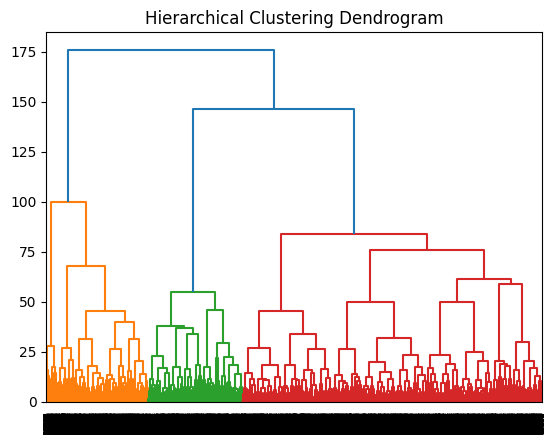

In [65]:
plot_dendrogram(sample_rb_scl, 'ward')

#### Models

##### 3 clusters

In [102]:
sample_original['rb_ward3'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 3
    ).fit_predict(sample_rb_scl)

In [103]:
groupby_mean(sample_original, 'rb_ward3', True, 12)

# observations per cluster: [5035, 14721, 4670]


rb_ward3,0,1,2
frequency_items,36.980000,37.490000,41.630000
potencial_score,26.300000,14.150000,80.180000
longevity_months,14.160000,14.770000,16.600000
relevance_criteria,2.000000,1.910000,1.890000
recency_in_weeks,15.620000,15.320000,14.720000
promotional_percentage,36.340000,4.820000,5.750000
returns,0.090000,0.020000,0.050000
flaged,0.000000,0.010000,0.020000
credit_factor,1.330000,0.800000,0.780000
zip_code,4.130000,3.870000,7.690000


promo | general | score

##### 4 clusters

In [104]:
sample_original['rb_ward4'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 4
    ).fit_predict(sample_rb_scl)

In [105]:
groupby_mean(sample_original, 'rb_ward4', True, 12)

# observations per cluster: [14721, 4463, 4670, 572]


rb_ward4,0,1,2,3
frequency_items,37.490000,36.760000,41.630000,38.620000
potencial_score,14.150000,24.490000,80.180000,40.420000
longevity_months,14.770000,13.840000,16.600000,16.710000
relevance_criteria,1.910000,2.000000,1.890000,2.000000
recency_in_weeks,15.320000,15.740000,14.720000,14.650000
promotional_percentage,4.820000,30.780000,5.750000,79.720000
returns,0.020000,0.040000,0.050000,0.450000
flaged,0.010000,0.000000,0.020000,0.000000
credit_factor,0.800000,1.390000,0.780000,0.920000
zip_code,3.870000,3.950000,7.690000,5.510000


general | promo1 | score | promo2

##### 5 clusters

In [106]:
sample_original['rb_ward5'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 5
    ).fit_predict(sample_rb_scl)

In [107]:
groupby_mean(sample_original, 'rb_ward5', True, 12)

# observations per cluster: [10280, 4463, 4670, 572, 4441]


rb_ward5,0,1,2,3,4
frequency_items,37.050000,36.760000,41.630000,38.620000,38.510000
potencial_score,15.170000,24.490000,80.180000,40.420000,11.790000
longevity_months,16.670000,13.840000,16.600000,16.710000,10.370000
relevance_criteria,1.870000,2.000000,1.890000,2.000000,2.000000
recency_in_weeks,13.930000,15.740000,14.720000,14.650000,18.560000
promotional_percentage,4.410000,30.780000,5.750000,79.720000,5.770000
returns,0.020000,0.040000,0.050000,0.450000,0.020000
flaged,0.010000,0.000000,0.020000,0.000000,0.000000
credit_factor,0.800000,1.390000,0.780000,0.920000,0.800000
zip_code,4.190000,3.950000,7.690000,5.510000,3.130000


general | promo1 | score | promo2 | lowscore?+new

#### Comparison

In [173]:
clusters_comparison(sample_original, 'rb_ward4', 'rb_ward3')

,rb_ward3 0 Cluster,rb_ward3 1 Cluster,rb_ward3 2 Cluster
rb_ward4 0 Cluster,0,14721,0
rb_ward4 1 Cluster,4463,0,0
rb_ward4 2 Cluster,0,0,4670
rb_ward4 3 Cluster,572,0,0


In [174]:
clusters_comparison(sample_original, 'rb_ward5', 'rb_ward4')

,rb_ward4 0 Cluster,rb_ward4 1 Cluster,rb_ward4 2 Cluster,rb_ward4 3 Cluster
rb_ward5 0 Cluster,10280,0,0,0
rb_ward5 1 Cluster,0,4463,0,0
rb_ward5 2 Cluster,0,0,4670,0
rb_ward5 3 Cluster,0,0,0,572
rb_ward5 4 Cluster,4441,0,0,0


### Inter clustering Comparison <a id='icc'></a>

#### Scaler Comparison
In this section it is possible understand that **minmax scaler** is the one that presented more **consistent results**, in the sense that independently of the clustering method used (hierarchical with ward or kmeans), the clustering solutions it presented were very similar and the observations belonging to the clusters formed also had less variation.

##### No Scaler

In [175]:
clusters_comparison(sample_original, 'no_kmeans3', 'no_ward3')

,no_ward3 0 Cluster,no_ward3 1 Cluster,no_ward3 2 Cluster
no_kmeans3 0 Cluster,10304,0,75
no_kmeans3 1 Cluster,0,5744,0
no_kmeans3 2 Cluster,1157,0,7146


In [176]:
clusters_comparison(sample_original, 'no_kmeans4', 'no_ward4')

,no_ward4 0 Cluster,no_ward4 1 Cluster,no_ward4 2 Cluster,no_ward4 3 Cluster
no_kmeans4 0 Cluster,0,553,7142,0
no_kmeans4 1 Cluster,5531,0,0,0
no_kmeans4 2 Cluster,0,1643,72,8197
no_kmeans4 3 Cluster,213,1068,7,0


In [177]:
clusters_comparison(sample_original, 'no_kmeans5', 'no_ward5')

,no_ward5 0 Cluster,no_ward5 1 Cluster,no_ward5 2 Cluster,no_ward5 3 Cluster,no_ward5 4 Cluster
no_kmeans5 0 Cluster,0,2530,47,159,0
no_kmeans5 1 Cluster,4629,0,0,0,446
no_kmeans5 2 Cluster,0,200,125,8038,0
no_kmeans5 3 Cluster,0,482,7049,0,0
no_kmeans5 4 Cluster,50,52,0,0,619


##### Standard Scaler

No options were tested with the same number of clusters

##### MinMax Scaler

In [178]:
clusters_comparison(sample_original, 'mm_kmeans3', 'mm_ward3')

,mm_ward3 0 Cluster,mm_ward3 1 Cluster,mm_ward3 2 Cluster
mm_kmeans3 0 Cluster,18066,0,0
mm_kmeans3 1 Cluster,362,0,4973
mm_kmeans3 2 Cluster,81,944,0


In [179]:
clusters_comparison(sample_original, 'mm_kmeans4', 'mm_ward4')

,mm_ward4 0 Cluster,mm_ward4 1 Cluster,mm_ward4 2 Cluster,mm_ward4 3 Cluster
mm_kmeans4 0 Cluster,9832,515,0,0
mm_kmeans4 1 Cluster,0,362,4973,0
mm_kmeans4 2 Cluster,7204,515,0,0
mm_kmeans4 3 Cluster,0,81,0,944


In [180]:
clusters_comparison(sample_original, 'mm_kmeans5', 'mm_ward5')

,mm_ward5 0 Cluster,mm_ward5 1 Cluster,mm_ward5 2 Cluster,mm_ward5 3 Cluster,mm_ward5 4 Cluster
mm_kmeans5 0 Cluster,6250,11,0,0,983
mm_kmeans5 1 Cluster,0,81,0,944,0
mm_kmeans5 2 Cluster,0,270,4973,0,0
mm_kmeans5 3 Cluster,0,1105,0,0,0
mm_kmeans5 4 Cluster,3051,6,0,0,6752


##### Robust Scaler

In [181]:
clusters_comparison(sample_original, 'rb_kmeans3', 'rb_ward3')

,rb_ward3 0 Cluster,rb_ward3 1 Cluster,rb_ward3 2 Cluster
rb_kmeans3 0 Cluster,447,28,4623
rb_kmeans3 1 Cluster,3180,9,47
rb_kmeans3 2 Cluster,1408,14684,0


In [182]:
clusters_comparison(sample_original, 'rb_kmeans4', 'rb_ward4')

,rb_ward4 0 Cluster,rb_ward4 1 Cluster,rb_ward4 2 Cluster,rb_ward4 3 Cluster
rb_kmeans4 0 Cluster,7104,1038,0,0
rb_kmeans4 1 Cluster,7590,616,0,0
rb_kmeans4 2 Cluster,8,2365,47,572
rb_kmeans4 3 Cluster,19,444,4623,0


## 4.3. DBScan <a id='dbs'></a>

In this section **DBScan** will be run using the algorithm that preformed best until now (**minmax**). Firstly, a Kdist graph was plotted (to help find the right eps value) and, then, **parameters were adjusted**, and clustering solutions created. These solutions were once again compared.

### MinMax Scaler <a id='dbs-mm'></a>

#### Plot

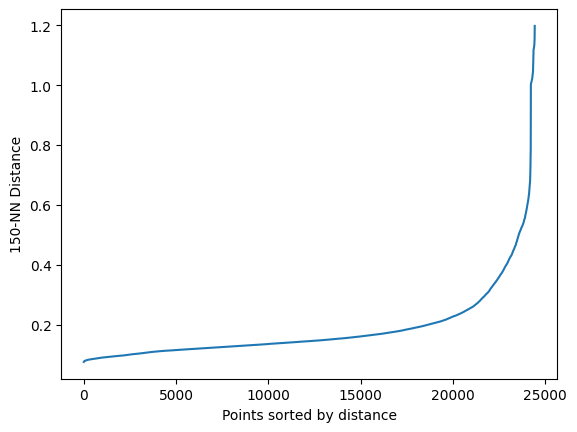

In [148]:
plot_kdist_graph(sample_mm_scl, demographic_metrics)

#### Models

##### 3 clusters

In [149]:
dbscan = DBSCAN(eps=0.22, min_samples=90, n_jobs=4)
dbscan_labels = dbscan.fit_predict(sample_mm_scl)
dbscan_n_clusters = len(np.unique(dbscan_labels))
sample_original['mm_dbs3'] = dbscan_labels

print("Number of estimated clusters  : %d" % dbscan_n_clusters)
print("Counter of cluster labels     :", Counter(dbscan_labels))
print("Percentage of noise rows      :", round(100*Counter(dbscan_labels)[-1]/sample_mm_scl.shape[0],2))

Number of estimated clusters  : 4
Counter of cluster labels     : Counter({np.int64(0): 16864, np.int64(1): 4835, np.int64(-1): 2237, np.int64(2): 490})
Percentage of noise rows      : 9.16


In [150]:
groupby_mean(sample_original, 'mm_dbs3', True)

# observations per cluster: [2237, 16864, 4835, 490]


mm_dbs3,-1,0,1,2
frequency_items,40.010000,37.320000,40.270000,38.640000
potencial_score,41.840000,13.690000,80.120000,6.780000
longevity_months,16.650000,14.410000,16.530000,12.270000
relevance_criteria,1.370000,2.000000,2.000000,1.000000
recency_in_weeks,14.780000,15.440000,14.820000,16.180000
promotional_percentage,23.000000,10.550000,10.650000,0.000000
returns,0.460000,0.000000,0.000000,0.000000
flaged,0.090000,0.000000,0.000000,0.000000
credit_factor,0.770000,0.950000,0.810000,0.890000
zip_code,5.660000,3.730000,7.660000,2.090000


##### 4 clusters

In [152]:
dbscan = DBSCAN(eps=0.23, min_samples=90, n_jobs=4)
dbscan_labels = dbscan.fit_predict(sample_mm_scl)
dbscan_n_clusters = len(np.unique(dbscan_labels))
sample_original['mm_dbs4'] = dbscan_labels

print("Number of estimated clusters  : %d" % dbscan_n_clusters)
print("Counter of cluster labels     :", Counter(dbscan_labels))
print("Percentage of noise rows      :", round(100*Counter(dbscan_labels)[-1]/sample_mm_scl.shape[0],2))

Number of estimated clusters  : 5
Counter of cluster labels     : Counter({np.int64(0): 16885, np.int64(1): 4851, np.int64(-1): 1986, np.int64(2): 563, np.int64(3): 141})
Percentage of noise rows      : 8.13


In [153]:
groupby_mean(sample_original, 'mm_dbs4', True)

# observations per cluster: [1986, 16885, 4851, 563, 141]


mm_dbs4,-1,0,1,2,3
frequency_items,40.100000,37.330000,40.310000,38.110000,39.060000
potencial_score,45.010000,13.680000,80.130000,10.410000,1.160000
longevity_months,16.700000,14.420000,16.520000,12.720000,15.990000
relevance_criteria,1.470000,2.000000,2.000000,1.000000,0.000000
recency_in_weeks,14.620000,15.440000,14.820000,16.060000,17.010000
promotional_percentage,24.900000,10.610000,10.770000,0.010000,0.000000
returns,0.520000,0.000000,0.000000,0.000000,0.000000
flaged,0.110000,0.000000,0.000000,0.000000,0.000000
credit_factor,0.810000,0.950000,0.810000,0.880000,0.280000
zip_code,5.970000,3.730000,7.660000,2.810000,0.390000


##### 5 clusters

In [155]:
dbscan = DBSCAN(eps=0.1, min_samples=35, n_jobs=4)
dbscan_labels = dbscan.fit_predict(sample_mm_scl)
sample_original['mm_dbs5'] = dbscan_labels
dbscan_n_clusters = len(np.unique(dbscan_labels))

print("Number of estimated clusters  : %d" % dbscan_n_clusters)
print("Counter of cluster labels     :", Counter(dbscan_labels))
print("Percentage of noise rows      :", round(100*Counter(dbscan_labels)[-1]/sample_mm_scl.shape[0],2))

Number of estimated clusters  : 6
Counter of cluster labels     : Counter({np.int64(0): 8293, np.int64(-1): 7388, np.int64(2): 5392, np.int64(1): 3267, np.int64(3): 58, np.int64(4): 28})
Percentage of noise rows      : 30.25


In [156]:
groupby_mean(sample_original, 'mm_dbs5', True)

# observations per cluster: [7388, 8293, 3267, 5392, 58, 28]


mm_dbs5,-1,0,1,2,3,4
frequency_items,41.160000,38.530000,38.430000,33.390000,37.190000,39.460000
potencial_score,39.220000,0.510000,79.580000,29.890000,0.600000,0.970000
longevity_months,17.330000,12.020000,16.000000,15.810000,10.360000,13.540000
relevance_criteria,1.750000,2.000000,2.000000,2.000000,1.000000,1.000000
recency_in_weeks,14.550000,15.880000,15.230000,15.330000,14.950000,18.430000
promotional_percentage,20.760000,9.530000,5.790000,5.470000,0.000000,0.000000
returns,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000
flaged,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000
credit_factor,0.880000,1.050000,0.770000,0.790000,0.970000,1.040000
zip_code,5.970000,0.380000,7.640000,7.680000,0.280000,0.570000


#### Comparison

In [186]:
clusters_comparison(sample_original, 'mm_dbs4', 'mm_dbs3')

,mm_dbs3 0 Cluster,mm_dbs3 1 Cluster,mm_dbs3 2 Cluster,mm_dbs3 3 Cluster
mm_dbs4 0 Cluster,1986,0,0,0
mm_dbs4 1 Cluster,21,16864,0,0
mm_dbs4 2 Cluster,16,0,4835,0
mm_dbs4 3 Cluster,73,0,0,490
mm_dbs4 4 Cluster,141,0,0,0


In [187]:
clusters_comparison(sample_original, 'mm_dbs5', 'mm_dbs4')

,mm_dbs4 0 Cluster,mm_dbs4 1 Cluster,mm_dbs4 2 Cluster,mm_dbs4 3 Cluster,mm_dbs4 4 Cluster
mm_dbs5 0 Cluster,1986,3200,1584,477,141
mm_dbs5 1 Cluster,0,8293,0,0,0
mm_dbs5 2 Cluster,0,0,3267,0,0
mm_dbs5 3 Cluster,0,5392,0,0,0
mm_dbs5 4 Cluster,0,0,0,58,0
mm_dbs5 5 Cluster,0,0,0,28,0


### Conclusions <a id='conc'></a>

Based on the results obtained, DBScan was discarded from further study as it recurrently gave clustering result with either one very lage cluster along other very small ones or with a significant amount of outliers. 

Having said this, the 2 solutions that were deemed most fit until now were ward hierarchical clustering and kmeans both with 5 clusters. These solutions were chosen as they provided clustering solutions that were consistent with the clusters most frequently found in the testing phase as well as ones that made sense.

# 5. UMAP <a id='u'></a>

In this section, the four clustering solutions mentioned in the [conclusion of the previous section](#conc) (minmax kmeans with 4 clusters, minmax kmeans with 5 clusters, minmax ward with 4 clusters, and minmax ward with 5 clusters) were visualized using umap to ensure the custers' consistency. Then, if deemed acceptable, the clustering solutions were implemented to the whole dataset.

### Create the embeddings

In [26]:
umap_object = umap.UMAP(random_state=1)

In [ ]:
# embeddings for samples
umap_embedding_mm = umap_object.fit_transform(sample_mm_scl)

In [27]:
# embeddings for the whole dataset
umap_embedding_mm_all = umap_object.fit_transform(demographic_mm_scl)

### UMAP for samples

##### MinMax - Kmeans - 5 clusters

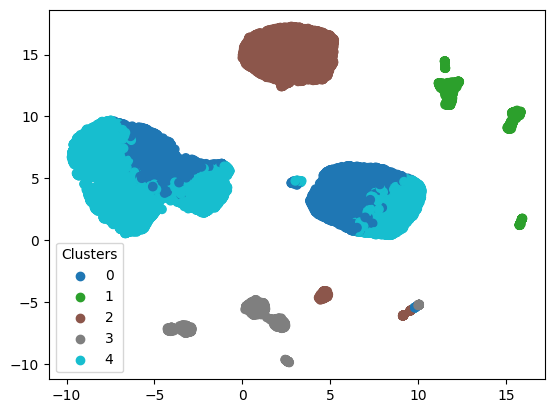

In [189]:
visualize_dimensionality_reduction(umap_embedding_mm, sample_original['mm_kmeans5'])

##### Minmax - Ward - 5 clusters

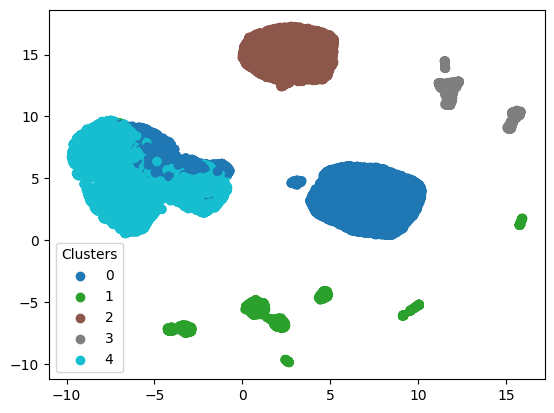

In [194]:
visualize_dimensionality_reduction(umap_embedding_mm, sample_original['mm_ward5'])

##### Conclusion

From these UMAPs, it was possible to conclude that ward hierarchical clustering likely provided a better separation of clusters, however, both solutions were brought to the next phase of joining clustering perspectives.

## Generalization to the whole dataset

### Kmeans - MinMax - 5 clusters

In [11]:
kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=20,  random_state = 1).fit(demographic_mm_scl)
demographic['mm_kmeans5'] = kmeans.predict(demographic_mm_scl)

In [12]:
groupby_mean(demographic, 'mm_kmeans5', True, 12)

# observations per cluster: [26001, 49331, 5648, 35985, 5164]


mm_kmeans5,0,1,2,3,4
frequency_items,40.800000,37.470000,38.550000,37.150000,40.150000
potencial_score,80.160000,8.880000,17.010000,20.230000,40.030000
longevity_months,16.460000,8.570000,14.890000,22.580000,16.180000
relevance_criteria,1.950000,2.000000,0.640000,2.000000,1.880000
recency_in_weeks,14.790000,15.640000,15.560000,15.180000,14.710000
promotional_percentage,11.490000,12.370000,0.030000,9.570000,29.460000
returns,0.000000,0.000000,0.000000,0.000000,1.000000
flaged,0.010000,0.000000,0.050000,0.000000,0.070000
credit_factor,0.810000,0.990000,0.600000,0.880000,0.960000
zip_code,7.670000,2.510000,3.690000,5.370000,5.270000


score | lowscore+new | nopromo | antiques | promo+returns

---

### Ward - MinMax - 5 clusters

Dividing the dataset in two to run the hierarchical clustering. This is needed as this algorithm is too computationally expensive to run with all the data.

In [13]:
dem1, dem2 = train_test_split(demographic, test_size=0.5, random_state=1, shuffle=True)
dem1_mm_scl, dem2_mm_scl = train_test_split(demographic_mm_scl, test_size=0.5, random_state=1, shuffle=True)


In [14]:
# Part 1
dem1['mm_ward5'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 5
    ).fit_predict(dem1_mm_scl)

In [15]:
# Part 2
dem2['mm_ward5'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 5
    ).fit_predict(dem2_mm_scl)

In [16]:
groupby_mean(dem1, 'mm_ward5', True)

# observations per cluster: [19414, 3650, 12343, 2393, 23264]


mm_ward5,0,1,2,3,4
frequency_items,36.070000,39.010000,41.010000,40.030000,38.430000
potencial_score,26.780000,30.280000,80.130000,39.060000,2.840000
longevity_months,18.180000,15.320000,16.500000,16.060000,11.430000
relevance_criteria,2.000000,0.750000,2.000000,1.920000,2.000000
recency_in_weeks,15.330000,15.370000,14.740000,14.830000,15.560000
promotional_percentage,7.940000,0.060000,12.040000,31.430000,13.910000
returns,0.000000,0.050000,0.000000,1.000000,0.000000
flaged,0.000000,0.130000,0.000000,0.000000,0.000000
credit_factor,0.830000,0.660000,0.810000,0.980000,1.050000
zip_code,6.990000,4.630000,7.670000,5.120000,1.000000


antiques | nopromo | score | promo+returns | lowscore+new

In [17]:
groupby_mean(dem2, 'mm_ward5', True)

# observations per cluster: [3771, 25425, 12310, 2408, 17151]


mm_ward5,0,1,2,3,4
frequency_items,39.080000,36.500000,40.680000,39.590000,38.550000
potencial_score,30.530000,12.690000,80.070000,39.030000,14.970000
longevity_months,15.150000,9.110000,16.480000,16.070000,22.380000
relevance_criteria,0.760000,2.000000,2.000000,1.930000,2.000000
recency_in_weeks,15.380000,15.260000,14.800000,14.720000,15.700000
promotional_percentage,0.070000,13.470000,12.160000,31.950000,7.830000
returns,0.050000,0.000000,0.000000,1.000000,0.000000
flaged,0.140000,0.000000,0.000000,0.000000,0.000000
credit_factor,0.640000,0.980000,0.810000,0.960000,0.890000
zip_code,4.570000,3.410000,7.670000,5.160000,4.150000


nopromo | lowscore+new | score | promo+returns | antiques

In [18]:
# Define the mapping from values to categories
clusters_mapping = {
    0: 1,
    1: 4,
    2: 2,
    3: 3,
    4: 0
}
# Create a new variable based on the existing variable
dem2['mm_ward5'] = [clusters_mapping[value] for value in dem2['mm_ward5']]

In [19]:
combined_dem = pd.concat([dem1, dem2], ignore_index=False)
combined_dem.sort_index(inplace=True)
combined_dem.to_csv('Data/New_Data/combined_dem_ward5.csv', index=True)

In [21]:
groupby_mean(combined_dem, 'mm_ward5', True, 12)

# observations per cluster: [36565, 7421, 24653, 4801, 48689]


mm_ward5,0,1,2,3,4
frequency_items,37.240000,39.050000,40.850000,39.810000,37.420000
potencial_score,21.240000,30.410000,80.100000,39.040000,7.980000
longevity_months,20.150000,15.240000,16.490000,16.060000,10.220000
relevance_criteria,2.000000,0.760000,2.000000,1.930000,2.000000
recency_in_weeks,15.510000,15.370000,14.770000,14.780000,15.400000
promotional_percentage,7.890000,0.070000,12.100000,31.690000,13.680000
returns,0.000000,0.050000,0.000000,1.000000,0.000000
flaged,0.000000,0.130000,0.000000,0.000000,0.000000
credit_factor,0.860000,0.650000,0.810000,0.970000,1.010000
zip_code,5.660000,4.600000,7.670000,5.140000,2.260000


antiques | nopromo | score | promo+returns | lowscore+new

### UMAP for the solutions

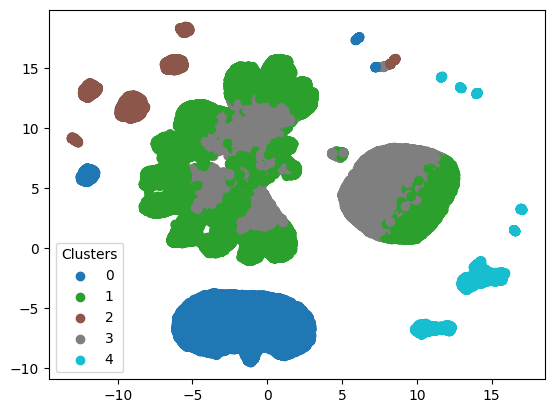

In [28]:
visualize_dimensionality_reduction(umap_embedding_mm_all, demographic['mm_kmeans5'])

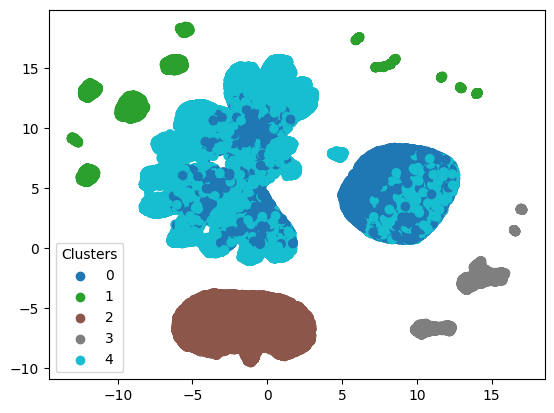

In [30]:
# WARDcombined_dem
visualize_dimensionality_reduction(umap_embedding_mm_all, combined_dem['mm_ward5'])

### Final Solution

In [33]:
demographic['mm_ward5'] = combined_dem['mm_ward5']
demographic

,frequency_items,potencial_score,longevity_months,relevance_criteria,recency_in_weeks,promotional_percentage,returns,flaged,credit_factor,zip_code,education,gender,mm_kmeans5,mm_ward5
0,38,-0.40,23,2,15,20,0,0,0.7,0,2.0,0.0,3,4
1,50,-0.30,24,2,10,36,0,0,0.7,0,0.0,NaN,3,0
2,48,1.60,32,2,20,0,0,0,0.7,0,0.0,1.0,3,0
3,46,-0.90,12,2,14,36,0,0,4.5,0,NaN,0.0,1,4
4,31,31.61,10,2,12,10,0,0,0.7,8,3.0,NaN,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122124,51,0.10,25,2,9,0,1,0,0.7,0,NaN,NaN,4,3
122125,42,30.99,23,2,15,0,0,0,0.7,8,0.0,0.0,3,0
122126,24,79.76,29,2,13,13,0,0,0.7,8,0.0,NaN,0,2
122127,29,0.50,14,2,11,0,0,0,0.7,0,NaN,NaN,1,4


In [36]:
demographic.to_csv('Data/Final_Data/demographic_perspective.csv', index=False)